# Sentiment Analysis using Face Landmarks with MediaPipe

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image

## MediaPipe Face Mesh

In [2]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

## Emotion Classifier

In [3]:
class EmotionClassifier:
    def __init__(self):
        self.eye_threshold = 0.15  # surprise
        self.mouth_open_threshold = 0.3  # surprise, happy
        self.eyebrow_threshold = 0.03  # surprise, fear
        self.lip_corner_threshold = 0.2  # happy

    def classify_emotion(self, landmarks, image_shape):
        h, w = image_shape[:2]
        landmarks = [(int(lm.x * w), int(lm.y * h)) for lm in landmarks.landmark]

        left_eye_ar = self._eye_aspect_ratio(landmarks[33], landmarks[159], landmarks[145], landmarks[133],
                                            landmarks[153], landmarks[154])
        right_eye_ar = self._eye_aspect_ratio(landmarks[362], landmarks[386], landmarks[374], landmarks[380],
                                             landmarks[381], landmarks[382])
        avg_eye_ar = (left_eye_ar + right_eye_ar) / 2

        mouth_openness = self._mouth_openness(landmarks[13], landmarks[14])

        left_eyebrow_raise = self._eyebrow_raise(landmarks[65], landmarks[159])
        right_eyebrow_raise = self._eyebrow_raise(landmarks[295], landmarks[386])
        avg_eyebrow_raise = (left_eyebrow_raise + right_eyebrow_raise) / 2

        lip_corner_movement = self._lip_corner_movement(landmarks[61], landmarks[291])

        if mouth_openness > self.mouth_open_threshold and avg_eye_ar > self.eye_threshold:
            return "Surprised", 0.9
        elif lip_corner_movement > self.lip_corner_threshold:
            return "Happy", 0.8
        elif avg_eyebrow_raise > self.eyebrow_threshold and avg_eye_ar > self.eye_threshold:
            return "Fear", 0.7
        elif lip_corner_movement < -self.lip_corner_threshold:
            return "Sad", 0.7
        else:
            return "Neutral", 0.6

    def _eye_aspect_ratio(self, p1, p2, p3, p4, p5, p6):

        vertical_dist1 = np.linalg.norm(np.array(p2) - np.array(p6))
        vertical_dist2 = np.linalg.norm(np.array(p3) - np.array(p5))
        horizontal_dist = np.linalg.norm(np.array(p1) - np.array(p4))
        ear = (vertical_dist1 + vertical_dist2) / (2.0 * horizontal_dist)
        return ear

    def _mouth_openness(self, upper_lip, lower_lip):

        return np.linalg.norm(np.array(upper_lip) - np.array(lower_lip))

    def _eyebrow_raise(self, eyebrow, eye):

        return (eye[1] - eyebrow[1]) / (eye[1] + 1e-6)

    def _lip_corner_movement(self, left_corner, right_corner):

        neutral_width = 0.2
        current_width = np.linalg.norm(np.array(left_corner) - np.array(right_corner))
        return current_width - neutral_width


emotion_classifier = EmotionClassifier()

## Detect Emotion

In [4]:
def detect_emotion(image_path=None, image_array=None):
    if image_path:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif image_array is not None:
        image = image_array
    else:
        raise ValueError("Either image_path or image_array must be provided")

    results = face_mesh.process(image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:

            emotion, confidence = emotion_classifier.classify_emotion(face_landmarks, image.shape)

            annotated_image = image.copy()
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles
                .get_default_face_mesh_tesselation_style())

            cv2.putText(annotated_image, f"{emotion} ({confidence:.2f})", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            return annotated_image, emotion, confidence
    return image, "No face detected", 0


## Image Emotion Detection

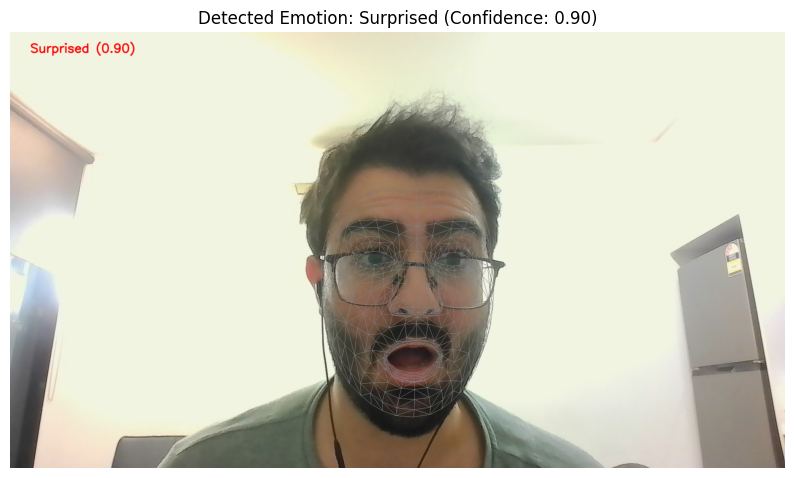

In [13]:
sample_image_path = r"C:\Users\Arian\Pictures\Camera Roll\My_surprised_face.jpg"  # Replace with your image path

try:
    result_image, emotion, confidence = detect_emotion(image_path=sample_image_path)

    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.title(f"Detected Emotion: {emotion} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error: {e}\nPlease provide a valid image path or use webcam demo.")

## Web-cam Emotion Detection

In [ ]:
def webcam_emotion_detection():
    # out = widgets.Output()
    # display(out)

    cap = cv2.VideoCapture(0)
    # if not cap.isOpened():
    #     print("Cannot open webcam")
    #     return
    #
    # stop_button = widgets.Button(description="Stop Webcam")
    # display(stop_button)
    #
    # def stop(b):
    #     cap.release()
    #     out.clear_output()
    #
    # stop_button.on_click(stop)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break


        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect emotion
        result_frame, emotion, confidence = detect_emotion(image_array=frame_rgb)


        result_frame_bgr = cv2.cvtColor(result_frame, cv2.COLOR_RGB2BGR)


        # with out:
        #     clear_output(wait=True)
            plt.imshow(result_frame)
            plt.axis('off')
            plt.title(f"Detected Emotion: {emotion} (Confidence: {confidence:.2f})")
            plt.show()

        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()

webcam_emotion_detection()

Output()

Button(description='Stop Webcam', style=ButtonStyle())